In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np

In [3]:
import keras
import pandas as pd

In [4]:
from tensorflow.keras import utils

In [5]:
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [6]:
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

In [7]:
import seaborn as sns

In [8]:
import math

In [9]:
def sig(x):
    return x/(1+x)

In [10]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


In [11]:
li = [1,122,15,46,66]

In [12]:
list(map(sig, li))

[0.5, 0.991869918699187, 0.9375, 0.9787234042553191, 0.9850746268656716]

In [13]:
list(map(sigmoid, li))

[0.7310585786300049, 1.0, 0.999999694097773, 1.0, 1.0]

In [14]:
df = pd.read_csv('data.csv').iloc[:,1:]

In [15]:
df.columns = ['user','movie','rate']

In [16]:
df.head()

,user,movie,rate
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


<AxesSubplot:xlabel='rate', ylabel='count'>

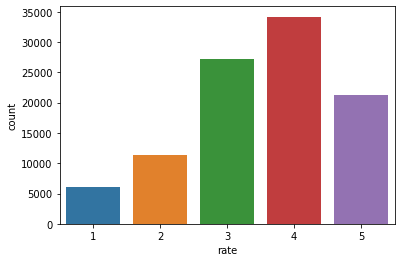

In [17]:
sns.countplot(df['rate'])

In [18]:
df_merged = df.copy()

In [19]:
df_merged.rename({'user':'user','movie':'item','rate':'rate'}, axis = 1, inplace = True)

In [20]:
ue = LabelEncoder()
ue.fit(df_merged['user'].values)
df_merged['user'] = ue.transform(df_merged['user'].values)
ie = LabelEncoder()
ie.fit(df_merged['item'].values)
df_merged['item'] = ie.transform(df_merged['item'].values)


In [21]:
train, test_data = train_test_split(df_merged, test_size=0.2)

In [22]:
n_users, n_item = len(df_merged.user.unique()), len(df_merged.item.unique())

In [30]:
n_latent_factors_user = 5
n_latent_factors_item = 5

item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors_item, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='Flattenitems')(item_embedding)
# item_vec = keras.layers.Dropout(0.2)(item_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
# user_vec = keras.layers.Dropout(0.2)(user_vec)


x = keras.layers.concatenate([item_vec, user_vec],name='Concat')
# concat = keras.layers.concatenate([item_vec, user_vec],name='Concat')
x = keras.layers.Dense(50,name='FullyConnected',activation='elu')(x)
x = keras.layers.Dropout(0.3,name='Dropout1')(x)

x = keras.layers.Dense(250,name='FullyConnected1',activation='elu')(x)
x = keras.layers.Dropout(0.2,name='Dropout2')(x)

x = keras.layers.Dense(500,name='FullyConnected-41',activation='relu')(x)
x = keras.layers.Dropout(0.5,name='Dropout41')(x)

x = keras.layers.Dense(750,name='FullyConnected-4',activation='relu')(x)
x = keras.layers.Dropout(0.2,name='Dropout4')(x)

x = keras.layers.Dense(700,name='FullyConnected-43',activation='relu')(x)
x = keras.layers.Dropout(0.2,name='Dropout43')(x)


x = keras.layers.Dense(300,name='FullyConnected-5',activation='relu')(x)
x = keras.layers.Dropout(0.1,name='Dropout5')(x)

x = keras.layers.Dense(150,name='FullyConnected-2',activation='elu')(x)
x = keras.layers.Dropout(0.3,name='Dropout3')(x)

x = keras.layers.Dense(50,name='FullyConnected-6', activation='elu')(x)
x = keras.layers.Dropout(0.2,name='Dropout6')(x)

result = keras.layers.Dense(1, activation='elu',name='Activation',)(x)
adam = Adam(lr=0.001,decay=1e-6, beta_1=0.9, beta_2=0.999)
model = keras.Model([user_input, item_input,], result,)
# model = keras.Model([user_input, item_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [31]:
train.shape

(80000, 3)

In [35]:
utils.model_to_dot(model, )

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
es1 = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [66]:
history = model.fit([train.user, train.item], train.rate, epochs=5, verbose=1,workers=-1, batch_size=256,validation_split=.1, callbacks=[es,es1])

Epoch 1/5
282/282 [==============================] - 12s 43ms/step - loss: 0.8404 - val_loss: 0.8040
Epoch 2/5
282/282 [==============================] - 15s 53ms/step - loss: 0.8169 - val_loss: 0.8242
Epoch 3/5
282/282 [==============================] - 15s 52ms/step - loss: 0.8026 - val_loss: 0.7890
Epoch 4/5
282/282 [==============================] - 15s 53ms/step - loss: 0.7899 - val_loss: 0.7704
Epoch 5/5
280/282 [============================>.] - ETA: 0s - loss: 0.7819- ETA: 0s - loss: 

KeyboardInterrupt: 

0.1480 

In [32]:
def get(number):
    user = ue.transform([number])
    test_data[test_data['user'].isin(user)]
    user_table = test_data[test_data['user'].isin(user)][['user']].drop_duplicates().copy()
    user_table = user_table.loc[:,~user_table.columns.duplicated()]
    limit = 100
    counter = 0
    u_list=[]
    p_list = []
    r_list = []
    for p in user_table.iterrows():
        user = p[1]['user']
        for product in range(1,n_item):
            u_list.append(user)
            p_list.append(product)
            r_list.append(model.predict([[user],[product]])[0][0])
        counter-=-1
        if counter%10==0:print(counter)
        if counter >limit:
            break
    result = pd.DataFrame({'user':u_list,'product':p_list,'rate':r_list})

    test = pd.DataFrame(columns=['user','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','p17','p18','p19','p20','p21','p22','p23','p24','p25','p26','p27','p28','p29','p30'])
    for i in range(user,user+1):
        asdf = result.loc[result.user==i].sort_values('rate',ascending = False).head(30)['product']
        lis = []
        lis.append(i)
        for j in asdf:
            lis.append(j)
        test.loc[len(test)] = lis
    test['user'] = ue.inverse_transform(list(test['user'].values))
    test['p1']=ie.inverse_transform(list(test['p1'].values))
    test['p2']=ie.inverse_transform(list(test['p2'].values))
    test['p3']=ie.inverse_transform(list(test['p3'].values))
    test['p4']=ie.inverse_transform(list(test['p4'].values))
    test['p5']=ie.inverse_transform(list(test['p5'].values))
    test['p6']=ie.inverse_transform(list(test['p6'].values))
    test['p7']=ie.inverse_transform(list(test['p7'].values))
    test['p8']=ie.inverse_transform(list(test['p8'].values))
    test['p9']=ie.inverse_transform(list(test['p9'].values))
    test['p10']=ie.inverse_transform(list(test['p10'].values))
    test['p11']=ie.inverse_transform(list(test['p11'].values))
    test['p12']=ie.inverse_transform(list(test['p12'].values))
    test['p13']=ie.inverse_transform(list(test['p13'].values))
    test['p14']=ie.inverse_transform(list(test['p14'].values))
    test['p15']=ie.inverse_transform(list(test['p15'].values))
    test['p16']=ie.inverse_transform(list(test['p16'].values))
    test['p17']=ie.inverse_transform(list(test['p17'].values))
    test['p18']=ie.inverse_transform(list(test['p18'].values))
    test['p19']=ie.inverse_transform(list(test['p19'].values))
    test['p20']=ie.inverse_transform(list(test['p20'].values))
    test['p21']=ie.inverse_transform(list(test['p21'].values))
    test['p22']=ie.inverse_transform(list(test['p22'].values))
    test['p23']=ie.inverse_transform(list(test['p23'].values))
    test['p24']=ie.inverse_transform(list(test['p24'].values))
    test['p25']=ie.inverse_transform(list(test['p25'].values))
    test['p26']=ie.inverse_transform(list(test['p26'].values))
    test['p27']=ie.inverse_transform(list(test['p27'].values))
    test['p28']=ie.inverse_transform(list(test['p28'].values))
    test['p29']=ie.inverse_transform(list(test['p29'].values))
    test['p30']=ie.inverse_transform(list(test['p30'].values))
    return test

In [54]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)


In [37]:
for user in df['user'].unique():
    print(df[df['user']==user]['merchant_name'])
    print(get(user).iloc[0,:])
    print("======================================================================")

KeyError: 'merchant_name'

In [61]:
prediction_lists = []
for items in test_data.head(5000).iterrows():
    user = items[1]['user']
    item = items[1]['item']
    prediction_lists.append(model.predict([[user],[item]])[0][0])

In [62]:
t_data['predicted_rating'] = prediction_lists


In [66]:
t_data[['user','item','rate','predicted_rating']].to_csv("rating_example_movie_data.csv")

# Checking the results

In [64]:
t_data[(t_data['predicted_rating']>.7) & (t_data['rate']>.7)][['user','item','rate','predicted_rating']].head(200)

,user,item,rate,predicted_rating
81671,649,490,3,3.988491
87209,591,150,4,3.999294
18761,233,471,2,2.075972
15857,21,454,5,3.014939
99174,737,203,4,3.976284
7995,71,123,4,3.993090
5210,58,384,4,3.988939
68791,806,510,5,4.846998
25475,300,131,4,4.002139
67148,937,121,1,3.014939
